# Text Tokenization TweetEval

## Import & Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from collections import Counter
from imblearn.over_sampling import SMOTE
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

c:\Users\walkervalentinus\Documents\PERKULIAHAN\Final_Year\SEMHAS\tasi2425112-3.8-english\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
clean_df = pd.read_csv("dataset/TwEv/clean.csv")

## Check Label Distribution (Imbalance Analysis)

In [3]:
# Label count
label_counts = clean_df["label"].value_counts().sort_index()
labels = label_counts.index
counts = label_counts.values

In [4]:
# Get majority and minority label
major_label = label_counts.idxmax()
minor_label = label_counts.idxmin()

In [5]:
# Count percentage 
total = counts.sum()
diff_percent = ((counts.max() - counts.min()) / total) * 100

In [6]:
plot_df = pd.DataFrame({
    "Label": labels,
    "Count": counts,
    "Category": ["Major" if l == major_label else "Minor" for l in labels]
})

In [7]:
color_map = {"Major": "blue", "Minor": "red"}

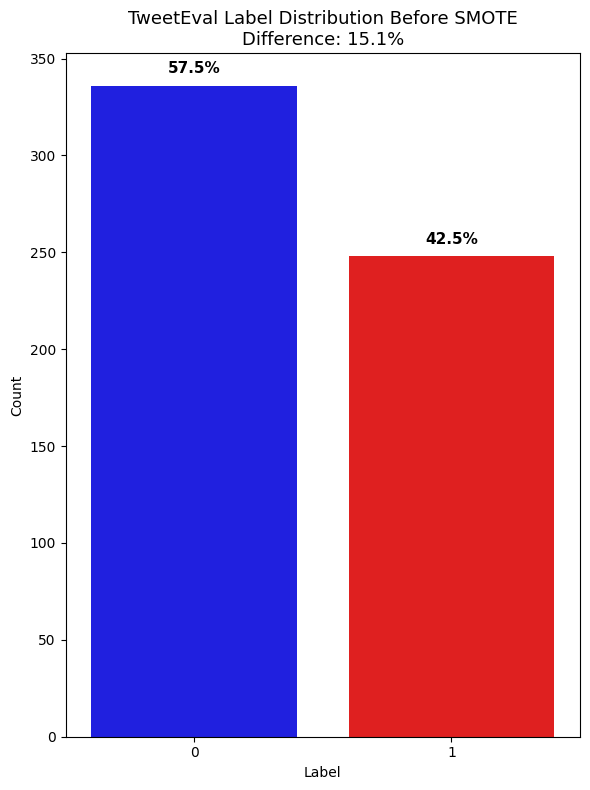

In [8]:
# Plot
plt.figure(figsize=(6, 8))
ax = sns.barplot(data=plot_df, x="Label", y="Count", hue="Category", palette=color_map, dodge=False)
ax.legend_.remove() 

# Add percentage above the bar
for i, count in enumerate(counts):
    pct = (count / total) * 100
    plt.text(i, count + 5, f"{pct:.1f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')

# Title and label
plt.title(f"TweetEval Label Distribution Before SMOTE\nDifference: {diff_percent:.1f}%", fontsize=13)
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Tokenization

In [9]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-lite-base-p1")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizerFast'. 
The class this function is called from is 'BertTokenizer'.


In [10]:
def tokenize_column(texts):
    return [tokenizer.encode(text, max_length=128, padding='max_length', truncation=True) for text in texts]

In [11]:
clean_df["token_no_emoji"] = tokenize_column(clean_df["No Stopword Text"].astype(str))
clean_df["token_with_emoji"] = tokenize_column(clean_df["Text with Emoji no Stopword"].astype(str))

In [12]:
clean_df.head(10)

,No Stopword Text,Text with Emoji no Stopword,label,token_no_emoji,token_with_emoji
0,woman fuck multipl time say yo dick small comp...,woman fuck multipl time say yo dick small comp...,1,"[2, 26878, 6286, 2948, 14804, 29844, 6199, 136...","[2, 26878, 6286, 2948, 14804, 29844, 6199, 136..."
1,go ex bf lie sack shit im done dude whi dump a...,go ex bf lie sack shit im done dude whi dump a...,1,"[2, 1563, 1669, 27924, 29568, 20365, 29839, 15...","[2, 1563, 1669, 27924, 29568, 20365, 29839, 15..."
2,wonder caitlyn get car servic,wonder caitlyn get car servic new moon face,0,"[2, 21215, 2256, 47, 27811, 6085, 2035, 28918,...","[2, 21215, 2256, 47, 27811, 6085, 2035, 28918,..."
3,uhhhhhh stupid littl bitch maam,uhhhhhh stupid littl bitch maam wink face,1,"[2, 11099, 22100, 29847, 1911, 6161, 29842, 16...","[2, 11099, 22100, 29847, 1911, 6161, 29842, 16..."
4,matter color girl still ho,matter color girl still ho face tear joy face ...,1,"[2, 25668, 29837, 12583, 12647, 25756, 3074, 3...","[2, 25668, 29837, 12583, 12647, 25756, 3074, 1..."
5,factcheck boycottunitedarlin aidingandabet fel...,factcheck boycottunitedarlin aidingandabet fel...,0,"[2, 2074, 20460, 4132, 2948, 6135, 1552, 11476...","[2, 2074, 20460, 4132, 2948, 6135, 1552, 11476..."
6,know women stupid like youre_ bitch pleas fuck...,know women stupid like youre_ bitch pleas fuck...,1,"[2, 11176, 22199, 1911, 6161, 29842, 9670, 728...","[2, 11176, 22199, 1911, 6161, 29842, 9670, 728..."
7,pronounc whore eye cunt,pronounc whore eye cunt red heart,0,"[2, 2023, 1867, 749, 11075, 757, 18293, 4250, ...","[2, 2023, 1867, 749, 11075, 757, 18293, 4250, ..."
8,women onli one think back rat hole never come ...,women onli one think back rat hole never come ...,1,"[2, 22199, 490, 849, 6307, 15139, 4585, 1745, ...","[2, 22199, 490, 849, 6307, 15139, 4585, 1745, ..."
9,never tri holla women diss school got call mis...,never tri holla women diss school got call mis...,0,"[2, 27090, 3647, 25482, 29832, 22199, 268, 298...","[2, 27090, 3647, 25482, 29832, 22199, 268, 298..."


## SMOTE Oversampling

In [13]:
X = np.array(clean_df["token_no_emoji"].tolist())
y = clean_df["label"].values

In [14]:
sm = SMOTE(random_state=42, sampling_strategy='auto')
X_resampled, y_resampled = sm.fit_resample(X, y)

## Check Oversampling Result 

In [15]:
print("\nTweetEval Label counts after SMOTE:")
print(Counter(y_resampled))


TweetEval Label counts after SMOTE:
Counter({1: 336, 0: 336})


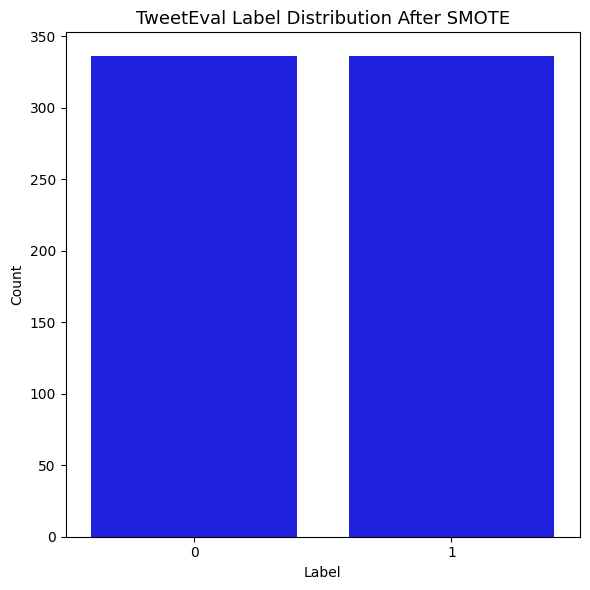

In [16]:
plt.figure(figsize=(6, 6))
sns.barplot(x=list(Counter(y_resampled).keys()), y=list(Counter(y_resampled).values()), color='blue')
plt.title("TweetEval Label Distribution After SMOTE", fontsize=13)
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Save Result

In [17]:
clean_df.to_csv("dataset/TwEv/tokenized_original.csv", index=False)

In [18]:
# Save SMOTE results for token_no_emoji
resampled_df_no_emoji = pd.DataFrame(X_resampled.tolist())
resampled_df_no_emoji['label'] = y_resampled
resampled_df_no_emoji.to_csv("dataset/TwEv/tokenized_smote_no_emoji.csv", index=False)

In [19]:
# Save SMOTE results for token_with_emoji (optional repeat)
X2 = np.array(clean_df["token_with_emoji"].tolist())
X2_resampled, y2_resampled = sm.fit_resample(X2, y)
resampled_df_with_emoji = pd.DataFrame(X2_resampled.tolist())
resampled_df_with_emoji['label'] = y2_resampled
resampled_df_with_emoji.to_csv("dataset/TwEv/tokenized_smote_with_emoji.csv", index=False)

## Train Test Split 

In [20]:
def split_and_save(dataframe, output_dir, name_prefix):
    # Split 80% train, 20% temp
    train_df, temp_df = train_test_split(dataframe, test_size=0.2, stratify=dataframe['label'], random_state=42)

    # Split 10% val, 10% test from temp (50:50 split of 20%)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save files
    train_df.to_csv(f"{output_dir}/{name_prefix}_train.csv", index=False)
    val_df.to_csv(f"{output_dir}/{name_prefix}_val.csv", index=False)
    test_df.to_csv(f"{output_dir}/{name_prefix}_test.csv", index=False)

In [21]:
df_no_emoji = pd.read_csv("dataset/TwEv/tokenized_smote_no_emoji.csv")
df_with_emoji = pd.read_csv("dataset/TwEv/tokenized_smote_with_emoji.csv")

split_and_save(df_no_emoji, "dataset/TwEv/TTVWE", "no_emoji")
split_and_save(df_with_emoji, "dataset/TwEv/TTVED", "with_emoji")